# Implementación en _Qiskit_ 1.0.2 del algoritmo de Shor. Análisis del circuito

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, qiskit
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer
import numpy as np
from fractions import Fraction
from qiskit.circuit.library import QFT
import pylatexenc

In [2]:
# Versión de Qiskit con la que trabajaremos
qiskit.__version__

'1.0.2'

En este cuadernillo se creará y analizará el circuito para la parte cuántica del algoritmo de Shor. Particularizaremos a $N=21$ y $x = 2$, de donde $\text{mcd}(x,N)=1$. Queremos entonces estimar el orden multiplicativo de 2 módulo 21. Para la exponenciación modular, nos servimos del siguiente código:

In [3]:
def exp_mod21(potencia):
    power = potencia
    qreg = QuantumRegister(5)
    exp_mod = QuantumCircuit(qreg, name='mod_ex')
    
    # x^power mod N
    exp_mod.cswap(0, 3, 4)
    exp_mod.cswap(0, 1, 2)
    exp_mod.cx(4, 2)
    exp_mod.cx(4, 0)
    exp_mod.swap(3, 4)
    exp_mod.swap(0, 3)
    exp_mod.swap(2, 3)
    exp_mod.swap(1, 2)
    
    # Si quisiéramos agilizar el proceso podemos añadir la instrucción de abajo. Esto se puede hacer si conocemos el orden de antemano
    #power = power % 6

    # Aplicacion reiterada
    circreg = QuantumRegister(5)
    circ = QuantumCircuit(circreg, name='2^' + str(potencia) + ' mod 21')

    if power == 0:
        return circ.id()
    else:
        for i in range(power):
            circ.append(exp_mod.to_gate(), [i for i in range(5)])
        return circ

Veamos cuál es el circuito dentro de la puerta a controlar en el algoritmo.

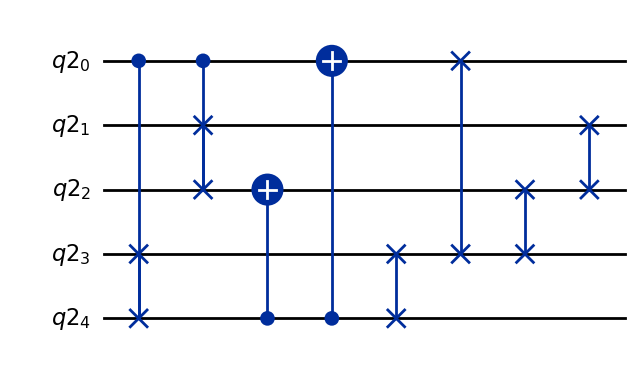

In [4]:
puerta_exp_mod = exp_mod21(1).decompose()
display(puerta_exp_mod.draw("mpl"))

Si realizamos un traspilado al _backend_ que emplearemos para la simulación ($\verb|qasm_simulator|$), observamos que no es necesario descomponer el circuito en puertas más elementales para su implementación.

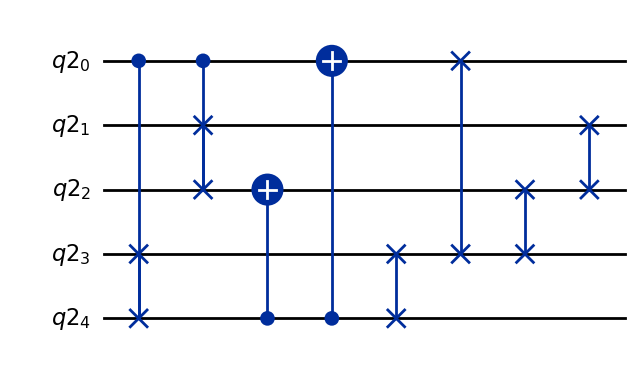

In [5]:
backend = Aer.get_backend("qasm_simulator")
puerta_exp_mod_t = transpile(puerta_exp_mod,backend)
display(puerta_exp_mod_t.draw("mpl"))

Podemos entonces analizar la profundidad y el número de puertas con el siguiente código:

In [6]:
print("Las puertas necesarias para la implementación son:\n")
print("Tipo de puerta --- Número")
for k, v in puerta_exp_mod_t.count_ops().items():
    print(f"{k:<20} {v}")
print("\nEl circuito tiene una profundidad de", puerta_exp_mod_t.depth())

Las puertas necesarias para la implementación son:

Tipo de puerta --- Número
swap                 4
cswap                2
cx                   2

El circuito tiene una profundidad de 8


Apliquemos esta puerta para el circuito que nos ocupa. En primer lugar, debemos inicializar las variables $N$ y $x$ de acuerdo al contexto en el que estamos.

In [7]:
# Inicializamos N y x
N = 21
x = 2

A continuación se crea el circuito cuántico correspondiente a la parte cuántica del algoritmo de Shor:

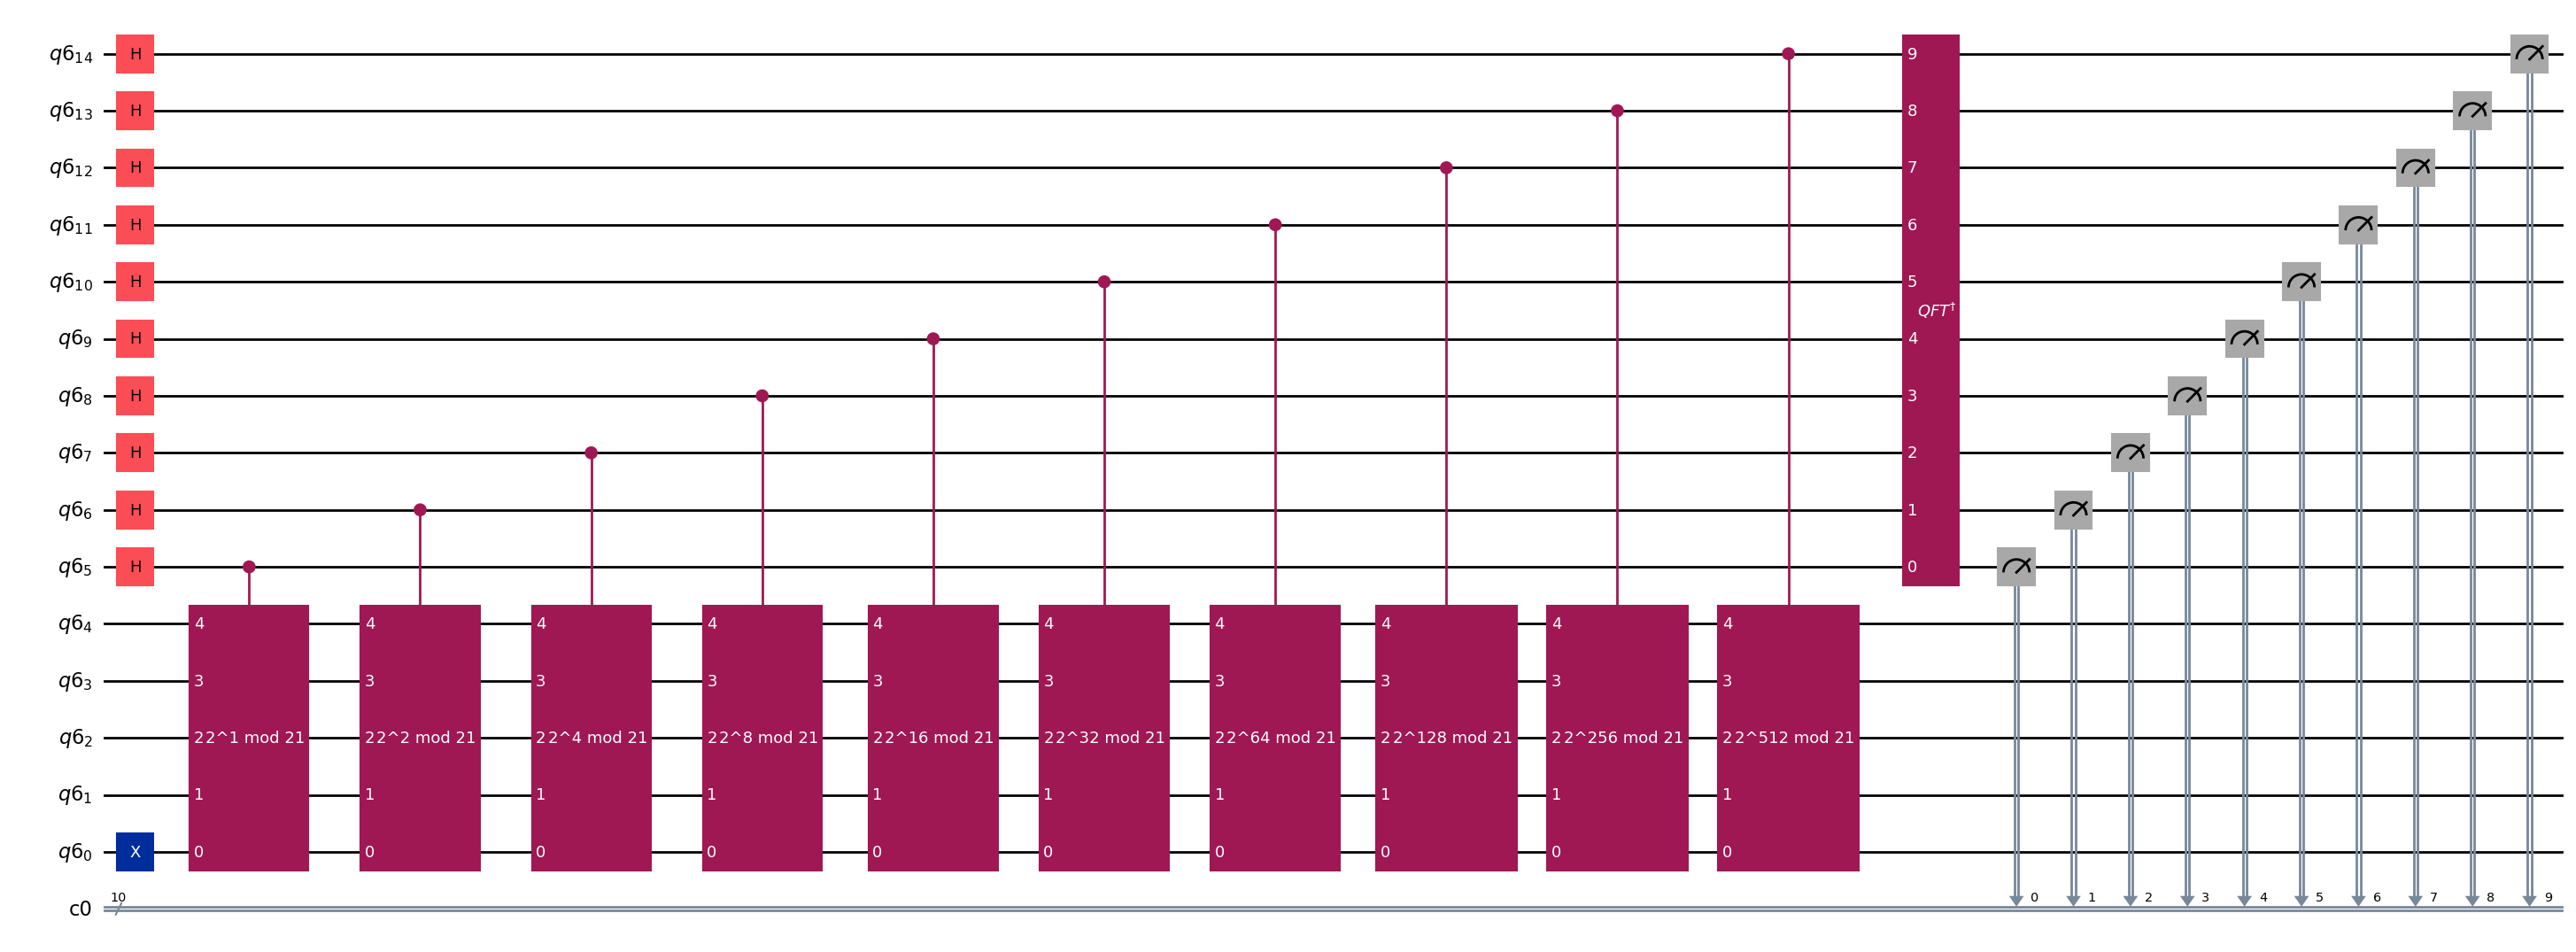

In [8]:
# Parte cuántica del algoritmo de Shor. Implementación en Qiskit 1.0.2
# Calculamos los qubits necesarios
n_in_qubits = int(np.ceil(np.log2(N)))
n_out_qubits = int(2*n_in_qubits)
n_qubits = n_out_qubits + n_in_qubits

# Circuito de Shor
shor_qreg = QuantumRegister(n_qubits)
shor_creg = ClassicalRegister(n_out_qubits)

shor_circ = QuantumCircuit(shor_qreg,shor_creg,name="Shor")

# Puertas hadamard a los 'n_in_qubits' qubits más significativos y la puerta X al qubit menos significativo de x^power mod N
shor_circ.h(range(n_in_qubits,n_qubits))
shor_circ.x(0)

# Puertas de exponeciación modular controladas
for i in range(n_out_qubits):
    shor_circ.append(exp_mod21(2**i).control(1),[n_in_qubits + i] + [i for i in range(n_in_qubits)])

# Transformada de Fourier cuántica inversa
shor_circ.append(QFT(n_out_qubits,inverse=True, name='$QFT^{\dagger}$'),[i for i in range(n_in_qubits,n_qubits)])

# Medidas
shor_circ.measure([shor_qreg[i] for i in range(n_in_qubits,n_qubits)],[shor_creg[i] for i in range(n_out_qubits)])

# Mostramos el circuito descomponiendo únicamente para ver las puertas controladas
display(shor_circ.decompose(gates_to_decompose=['c_2^' + str(power) + ' mod 21' for power in [2**i for i in range(n_out_qubits)]]).draw("mpl",reverse_bits=True,fold=-1))

Para revisar que el circuito es adecuado, ejecutémoslo (realizaremos 10000 _shots_), y filtremos los resultados.

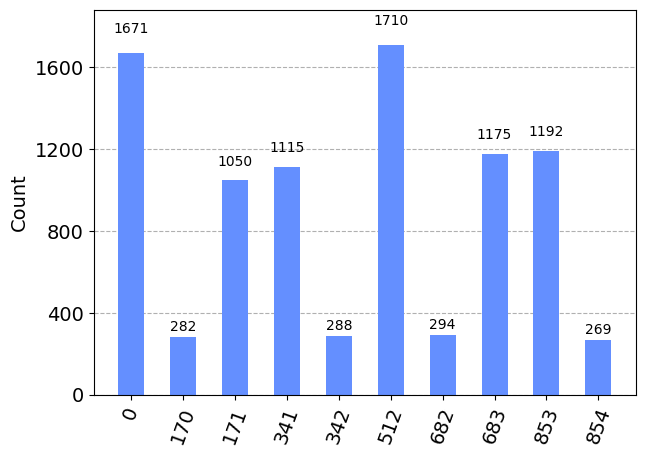

In [9]:
# Ejeccución en simulador
backend = Aer.get_backend("qasm_simulator")
shor_circ_t = transpile(shor_circ,backend)
result = backend.run(shor_circ_t,shots = 10000).result()

# Filtramos los resultados a aquellos superando el 1 por ciento de los shots realizados
counts_dec = {int(v,2):k for v,k in result.get_counts().items() if k > 0.01*10000}

# Histograma filtrado
display(plot_histogram(counts_dec))

En efecto, si hacemos uso de la teoría de las fracciones continuas podemos deducir el orden multiplicativo. En el siguiente código se muestra cómo.

In [10]:
# Calculamos todos los posibles periodos
for i in sorted(counts_dec):
    convergente = Fraction(i,2**n_out_qubits).limit_denominator(N)
    print("La medida es " + str(i) + " la convergente es " + str(convergente) + ". Periodo " + str(convergente.denominator))

La medida es 0 la convergente es 0. Periodo 1
La medida es 170 la convergente es 1/6. Periodo 6
La medida es 171 la convergente es 1/6. Periodo 6
La medida es 341 la convergente es 1/3. Periodo 3
La medida es 342 la convergente es 1/3. Periodo 3
La medida es 512 la convergente es 1/2. Periodo 2
La medida es 682 la convergente es 2/3. Periodo 3
La medida es 683 la convergente es 2/3. Periodo 3
La medida es 853 la convergente es 5/6. Periodo 6
La medida es 854 la convergente es 5/6. Periodo 6


El orden es 6, tal y como esperábamos. Aprovechando que hemos traspilado el circuito anterior, analicemos este.

In [11]:
print("Las puertas necesarias para la implementación son:\n")
print("Tipo de puerta --- Número")
for k, v in shor_circ_t.count_ops().items():
    print(f"{k:<20} {v}")
print("\nEl circuito tiene una profundidad de", shor_circ_t.depth())

Las puertas necesarias para la implementación son:

Tipo de puerta --- Número
ccx                  30690
u                    28644
cx                   28644
cu                   4092
cp                   45
h                    20
measure              10
swap                 5
p                    3
x                    1

El circuito tiene una profundidad de 85954


La cantidad de puertas y la profundidad del circuito son considerables. En el caso de aumentar en uno los qubits de precisión, las puertas que constituyen la exponenciación modular adicional prácticamente duplicarían al número de las ya existentes. Si bien no es preciso aumentar la precisión, para factorizar enteros cuya representación binaria exceda los 5 _qubits_ (suponiendo que conocemos el circuito de la exponenciación modular), el rendimiento del circuito se verá gravemente afectado con los medios actuales.